In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
from google.colab import drive
import pandas as pd
import numpy as np

drive.mount('/content/gdrive')
PATH = "gdrive/MyDrive/datasets/"
df = pd.read_pickle(PATH + "Corpus.pkl")


Mounted at /content/gdrive


In [4]:
df

,text,label,text_final
85,"[violence, against, women, reauthorization, ac...",0.0,"['withdraws', 'congress', 'approval', 'north',..."
86,"[voter, empowerment, act, of, 2013, -, voter, ...",0.0,"['authorizes', 'secretary', 'army', 'carry', '..."
87,"[border, security, ,, economic, opportunity, ,...",0.0,"['authorizes', 'secretary', 'army', 'carry', '..."
88,"[government, by, the, people, act, of, 2014, -...",0.0,"['modifies', 'project', 'improvement', 'shallo..."
89,"[nra, members, ', gun, safety, act, of, 2013, ...",0.0,"['disability', 'benefit', 'fairness', 'act', '..."
...,...,...,...
22214,"[bar, removal, of, individuals, who, dream, an...",0.0,NaN
22215,"[wildland, firefighter, retirement, and, disab...",0.0,NaN
22216,"[protect, our, heroes, act, of, 2016, this, bi...",0.0,NaN
22217,"[securing, active, and, fair, enforcement, act...",0.0,NaN


In [5]:
# Transformando el df al formato que necesitamos para TensorFlow
from sklearn.model_selection import train_test_split
import ast


# Primero separo la data en train y test
df['label'] = df['label'].astype(int)
new_df = df[['label', 'text_final']].copy()
new_df.rename(columns={'text_final': 'text'}, inplace=True)
new_df = new_df[['text', 'label']]
new_df.dropna(subset=['text'], inplace=True)
new_df['text'] = new_df['text'].apply(ast.literal_eval)
new_df['text'] = new_df['text'].apply(lambda x: ' '.join(x))

train_df, test_df = train_test_split(new_df, test_size=0.2, random_state=500)


In [6]:
# Salvamos la data en csv
train_df.to_csv('/content/train.csv', index=False)
test_df.to_csv('/content/test.csv', index=False)

In [7]:
# Cargamos los datasets a formato TensorFlow

train_dataset = tf.data.experimental.CsvDataset('/content/train.csv', [tf.string, tf.int64], header=True)
test_dataset = tf.data.experimental.CsvDataset('/content/test.csv', [tf.string, tf.int64], header=True)

In [8]:
# Verificando el Shape
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [9]:
# Verificando un ejemplo
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'right rent act grant eligible mortgagor subject foreclosure proceeding right continue occupy foreclosed property subject payment fair market rent period five year begin upon commencement occupancy property instruct secretary housing urban development hud monitor compliance act provide assistance eligible mortgagor exercise right act conduct outreach activity inform eligible mortgagor act'
label:  0


In [10]:
# Aquí ya arrancamos con todo el código de TensorFlow
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [11]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [13]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'act', 'require', 'state', 'program', 'sec',
       'federal', 'provide', 'service', 'secretary', 'use', 'amend',
       'fund', 'include', 'bill', 'agency', 'make', 'national', 'direct'],
      dtype='<U14')

In [14]:
encoded_example = encoder(example)[:3].numpy()
encoded_example


array([146,   1,   2])

In [15]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [16]:
print([layer.supports_masking for layer in model.layers])


[False, True, True, True, True]


In [17]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 6s 6s/step
[0.0041375]


In [18]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 70ms/step
[0.0041375]


In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [20]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
201/201 [==============================] - 67s 270ms/step - loss: 0.4339 - accuracy: 0.9109 - val_loss: 0.2778 - val_accuracy: 0.9255
Epoch 2/10
201/201 [==============================] - 36s 181ms/step - loss: 0.3052 - accuracy: 0.9109 - val_loss: 0.2727 - val_accuracy: 0.9255
Epoch 3/10
201/201 [==============================] - 29s 145ms/step - loss: 0.3017 - accuracy: 0.9109 - val_loss: 0.2712 - val_accuracy: 0.9255
Epoch 4/10
201/201 [==============================] - 27s 134ms/step - loss: 0.2996 - accuracy: 0.9109 - val_loss: 0.2695 - val_accuracy: 0.9255
Epoch 5/10
201/201 [==============================] - 27s 136ms/step - loss: 0.2970 - accuracy: 0.9109 - val_loss: 0.2685 - val_accuracy: 0.9255
Epoch 6/10
201/201 [==============================] - 27s 137ms/step - loss: 0.2947 - accuracy: 0.9109 - val_loss: 0.2691 - val_accuracy: 0.9255
Epoch 7/10
201/201 [==============================] - 28s 139ms/step - loss: 0.2908 - accuracy: 0.9109 - val_loss: 0.2698 - val_ac

In [21]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

51/51 [==============================] - 3s 68ms/step - loss: 0.2859 - accuracy: 0.9210
Test Loss: 0.2859099805355072
Test Accuracy: 0.9210199117660522


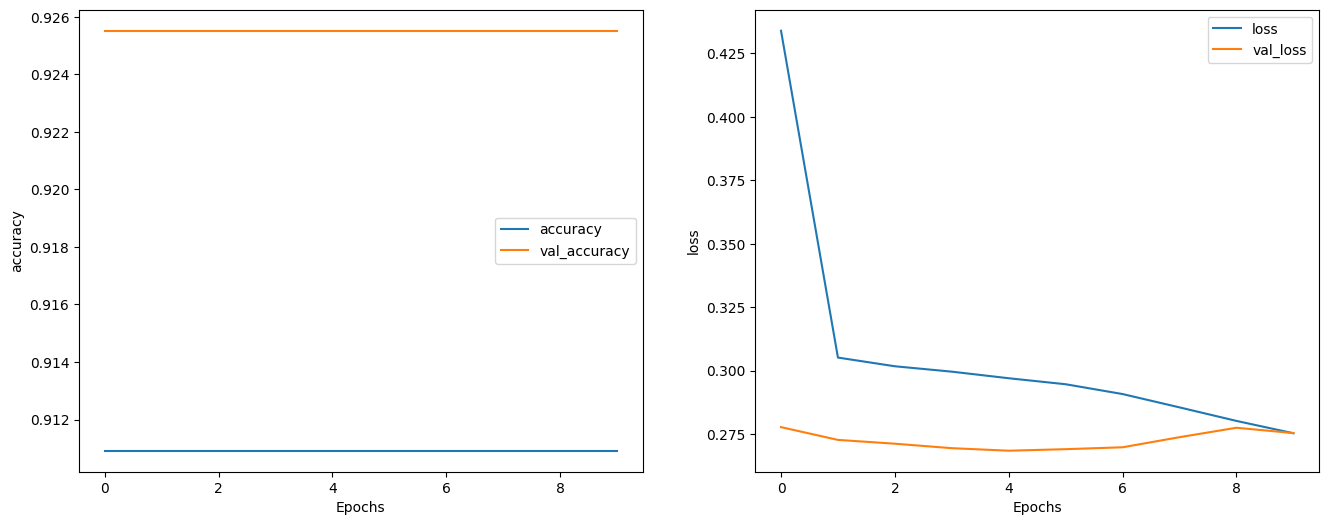

In [22]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [23]:
# Extra - Predicciones

predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.5).astype(int)
true_labels = test_dataset.map(lambda x, y: y).unbatch()
true_labels = np.array(list(true_labels))


51/51 [==============================] - 5s 50ms/step


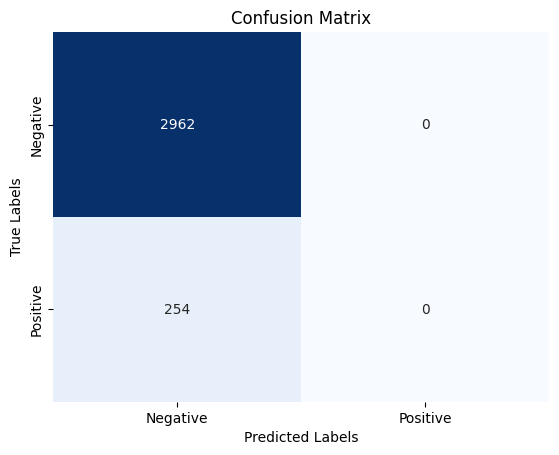

In [24]:
# Imprimimos la matriz de confusión 

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

# Set axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

## Oversampling

In [ ]:
!pip install imbalanced-learn

In [26]:
from imblearn.over_sampling import RandomOverSampler

In [35]:
X_train = train_df['text']
y_train = train_df['label']

oversampler = RandomOverSampler(random_state=500)

X_train = X_train.values.reshape(-1, 1)

X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

train_oversampled_df = pd.DataFrame({
    'text': X_train_oversampled.ravel(),
    'label': y_train_oversampled
})

train_oversampled_df.to_csv('/content/train_oversampled.csv', index=False)

train_oversampled_dataset = tf.data.experimental.CsvDataset('/content/train_oversampled.csv', [tf.string, tf.int64], header=True)

train_oversampled_dataset = train_oversampled_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_oversampled_dataset.map(lambda text, label: text))

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_oversampled_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
367/367 [==============================] - 77s 185ms/step - loss: 0.6624 - accuracy: 0.5842 - val_loss: 1.0585 - val_accuracy: 0.1260
Epoch 2/10
367/367 [==============================] - 46s 125ms/step - loss: 0.6902 - accuracy: 0.4882 - val_loss: 0.9260 - val_accuracy: 0.6167
Epoch 3/10
367/367 [==============================] - 44s 120ms/step - loss: 0.6796 - accuracy: 0.5283 - val_loss: 1.0780 - val_accuracy: 0.1021
Epoch 4/10
367/367 [==============================] - 45s 124ms/step - loss: 0.6542 - accuracy: 0.5753 - val_loss: 1.0283 - val_accuracy: 0.2953
Epoch 5/10
367/367 [==============================] - 42s 116ms/step - loss: 0.5923 - accuracy: 0.6686 - val_loss: 0.9709 - val_accuracy: 0.4859
Epoch 6/10
367/367 [==============================] - 42s 113ms/step - loss: 0.5246 - accuracy: 0.7284 - val_loss: 0.9187 - val_accuracy: 0.5714
Epoch 7/10
367/367 [==============================] - 43s 116ms/step - loss: 0.4797 - accuracy: 0.7660 - val_loss: 0.8531 - val_ac

In [36]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

51/51 [==============================] - 3s 51ms/step - loss: 0.7287 - accuracy: 0.7329
Test Loss: 0.7287089228630066
Test Accuracy: 0.7328979969024658


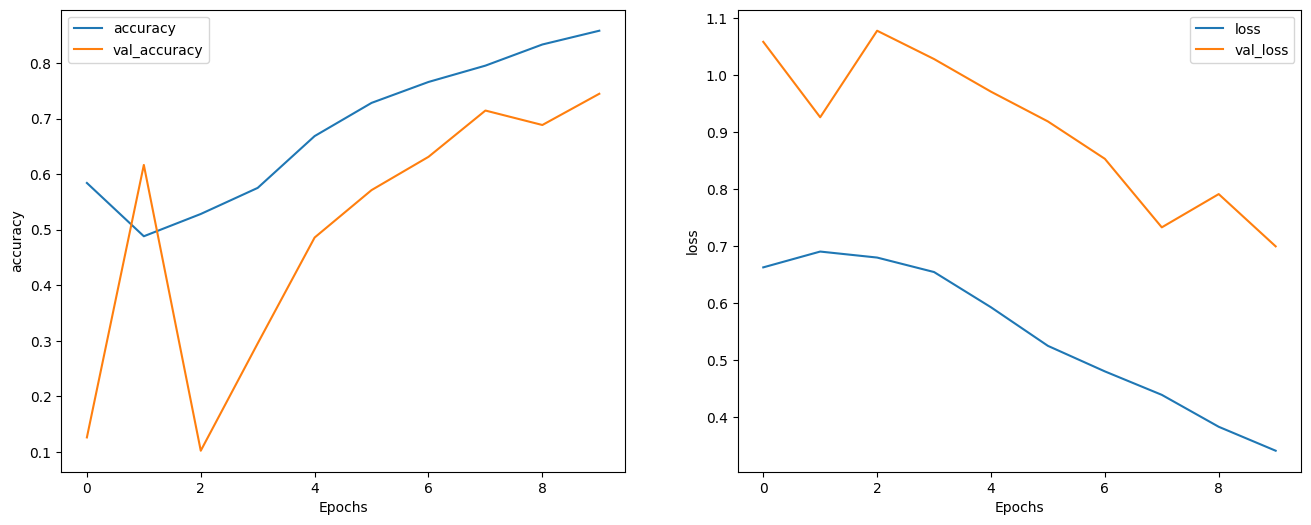

In [37]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [38]:
# Extra - Predicciones

predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.5).astype(int)
true_labels = test_dataset.map(lambda x, y: y).unbatch()
true_labels = np.array(list(true_labels))

51/51 [==============================] - 6s 65ms/step


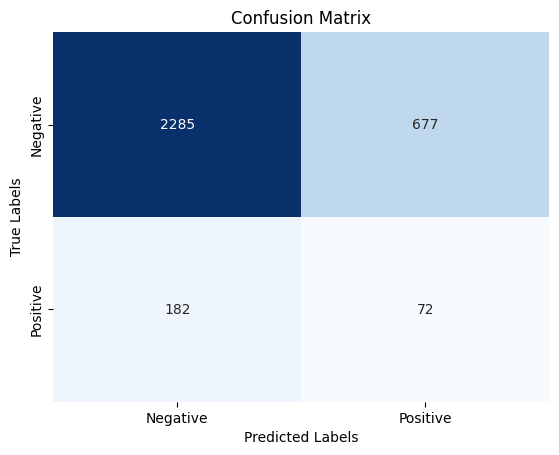

In [39]:
# Imprimimos la matriz de confusión 

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

# Set axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()

## Increasing Layers - Using oversampled dataset

In [40]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

history = model.fit(train_oversampled_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
367/367 [==============================] - 128s 297ms/step - loss: 0.6550 - accuracy: 0.5535 - val_loss: 1.1317 - val_accuracy: 0.0922
Epoch 2/10
367/367 [==============================] - 85s 231ms/step - loss: 0.6945 - accuracy: 0.4821 - val_loss: 0.7649 - val_accuracy: 0.9255
Epoch 3/10
367/367 [==============================] - 81s 217ms/step - loss: 0.6771 - accuracy: 0.5724 - val_loss: 1.0614 - val_accuracy: 0.1547
Epoch 4/10
367/367 [==============================] - 77s 210ms/step - loss: 0.6182 - accuracy: 0.6246 - val_loss: 1.0167 - val_accuracy: 0.4760
Epoch 5/10
367/367 [==============================] - 78s 213ms/step - loss: 0.5677 - accuracy: 0.6847 - val_loss: 0.9377 - val_accuracy: 0.5724
Epoch 6/10
367/367 [==============================] - 80s 217ms/step - loss: 0.5284 - accuracy: 0.7231 - val_loss: 0.8873 - val_accuracy: 0.6120
Epoch 7/10
367/367 [==============================] - 75s 205ms/step - loss: 0.4794 - accuracy: 0.7689 - val_loss: 0.8567 - val_a

In [41]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

51/51 [==============================] - 7s 142ms/step - loss: 0.9027 - accuracy: 0.6803
Test Loss: 0.9027429819107056
Test Accuracy: 0.68034827709198


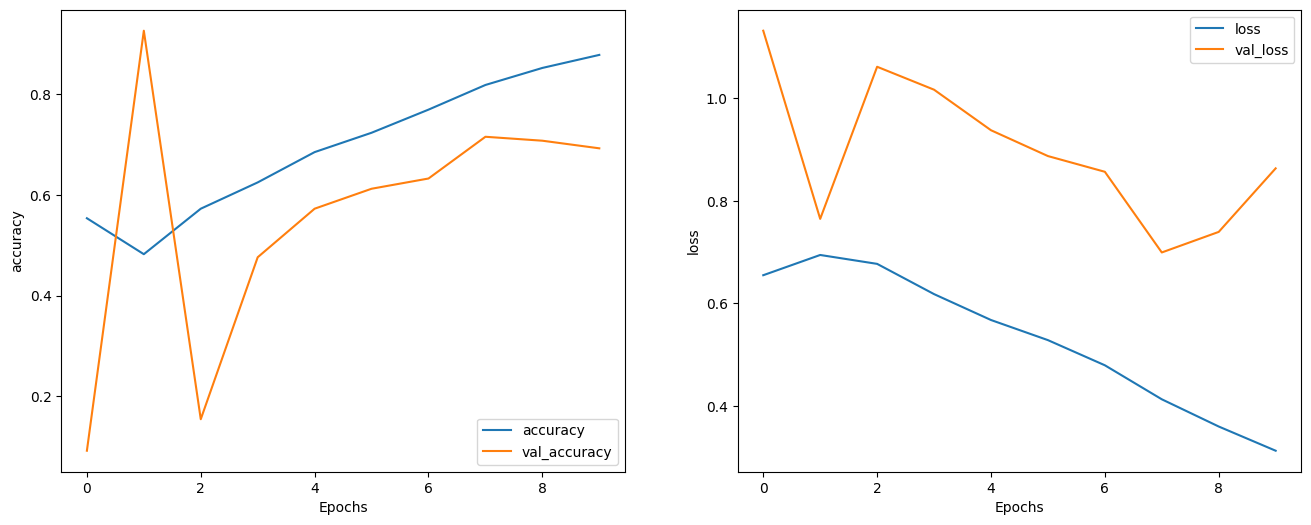

In [42]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [43]:
predictions = model.predict(test_dataset)
predicted_labels = (predictions > 0.5).astype(int)
true_labels = test_dataset.map(lambda x, y: y).unbatch()
true_labels = np.array(list(true_labels))

51/51 [==============================] - 12s 120ms/step


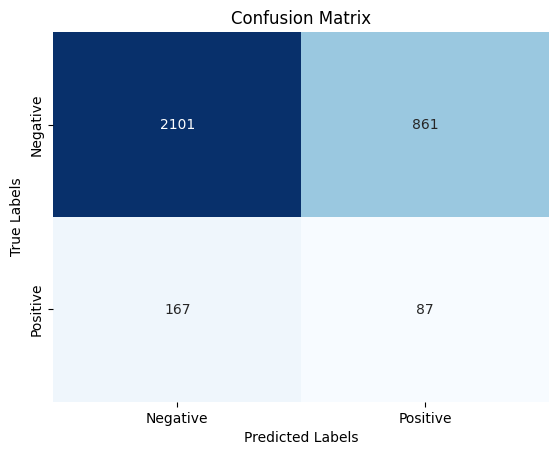

In [44]:
# Imprimimos la matriz de confusión 

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

# Set axis labels and title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Display the plot
plt.show()